# <font color='red'><ins>Práctica 2 FAA - Vecinos próximos & Regresión Logística</ins></font>
## Alejandro Santorum Varela - alejandro.santorum@estudiante.uam.es
## José Manuel Chacón Aguilera - josem.chacon@estudiante.uam.es

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [6]:
# My modules
from Datos import Datos
import EstrategiaParticionado
import Clasificador

# External modules
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Important to pre-install tabulate (pip install tabulate)
from tabulate import tabulate

# Init class Classifier
clasificador = Clasificador.Clasificador()

In [7]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data')
n1,m1 = db_pid.datos.shape
print("Numero de ejemplos:", n1,"| Numero de columnas:", m1)
print(db_pid.nominalAtributos)

Numero de ejemplos: 768 | Numero de columnas: 9
[False, False, False, False, False, False, False, False, True]


In [8]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data')
n2,m2 = db_wdbc.datos.shape
print("Numero de ejemplos:", n2,"| Numero de columnas:", m2)
print(db_wdbc.nominalAtributos)

Numero de ejemplos: 569 | Numero de columnas: 31
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]


## Normalización

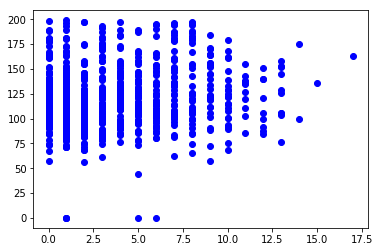

In [9]:
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

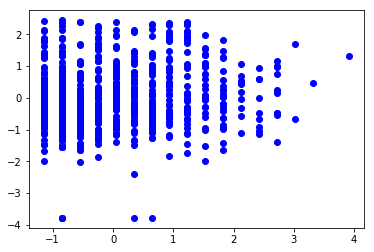

In [10]:
db_pid.normalizarDatos(db_pid.datos, db_pid.nominalAtributos)
data = db_pid.datos
plt.plot(data[:,0], data[:,1], 'bo')

Vamos a ver que la normalización es correcta

In [11]:
from sklearn import preprocessing

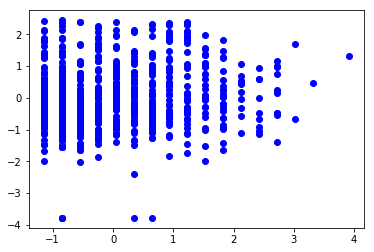

In [12]:
db_pid2 = Datos('../ConjuntosDatos/pima-indians-diabetes.data')

X_norm = preprocessing.scale(db_pid2.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

Vemos que las dos gráficas coinciden, indicándonos que, al menos para estos dos atributos, hemos normalizado correctamente

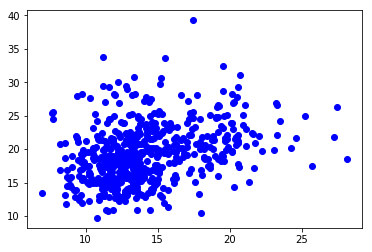

In [13]:
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

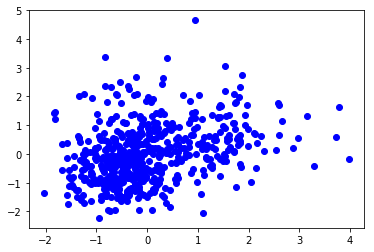

In [14]:
db_wdbc.normalizarDatos(db_wdbc.datos, db_wdbc.nominalAtributos)
data = db_wdbc.datos
plt.plot(data[:,0], data[:,1], 'bo')

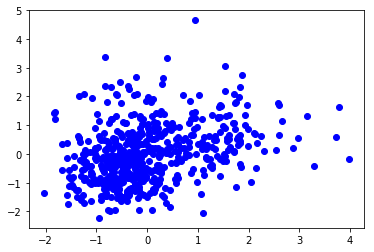

In [15]:
db_wdbc2 = Datos('../ConjuntosDatos/wdbc.data')

X_norm = preprocessing.scale(db_wdbc.datos[:,:-1])

plt.plot(X_norm[:,0], X_norm[:,1], 'bo')

De nuevo, las dos gráficas son iguales (la primera usando nuestras funciones de normalización y la segunda usando los métodos de sklearn). Ya estamos mucho más seguros de que nuestros métodos están bien implementados.

## Vecinos próximos

In [16]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
ndata, ncols = db_pid.datos.shape
print(ndata, ncols)

768 9


In [17]:
KNN = Clasificador.ClasificadorVecinosProximos(K=5, dist='euclidean')

In [18]:
strat_simple = EstrategiaParticionado.ValidacionSimple(0.8)

In [19]:
errores = clasificador.validacion(strat_simple, db_pid, KNN)
print(errores)

[0.30519480519480524]


In [20]:
KNNSK = Clasificador.ClasificadorVecinosProximosSK(K=5, dist='euclidean')

In [21]:
errores = clasificador.validacion(strat_simple, db_pid, KNNSK)
print(errores)

[0.27922077922077926]


In [22]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
ndata, ncols = db_wdbc.datos.shape
print(ndata, ncols)

569 31


In [23]:
errores = clasificador.validacion(strat_simple, db_wdbc, KNN)
print(errores)

[0.02631578947368418]


In [24]:
errores = clasificador.validacion(strat_simple, db_wdbc, KNNSK)
print(errores)

[0.03508771929824561]


## Regresión Logística

In [70]:
db_pid = Datos('../ConjuntosDatos/pima-indians-diabetes.data', normalize=True)
ndata, ncols = db_pid.datos.shape
print(ndata, ncols)

768 9


In [85]:
RL = Clasificador.ClasificadorRegresionLogistica(learning_rate=0.5, nepochs=110)

In [86]:
errores = clasificador.validacion(strat_simple, db_pid, RL)
print(errores)

[0.2727272727272727]


In [87]:
RL.W

array([-0.42988504,  0.45718747,  2.25871354, -0.04090096, -0.62269832,
       -1.35585374,  1.37867623,  1.29336895,  1.53931028])

In [92]:
RL_SKLR = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.5, sgd=False)

In [93]:
errores = clasificador.validacion(strat_simple, db_pid, RL_SKLR)
print(errores)

[0.23376623376623373]


In [104]:
RL_SKSGD = Clasificador.ClasificadorRegresionLogisticaSK(learning_rate=0.5, sgd=True)

In [105]:
errores = clasificador.validacion(strat_simple, db_pid, RL_SKSGD)
print(errores)

[0.2597402597402597]


In [65]:
db_wdbc = Datos('../ConjuntosDatos/wdbc.data', normalize=True)
ndata, ncols = db_wdbc.datos.shape
print(ndata, ncols)

569 31


In [66]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL)
print(errores)

[0.02631578947368418]


In [120]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL_SKLR)
print(errores)

[0.03508771929824561]


In [121]:
errores = clasificador.validacion(strat_simple, db_wdbc, RL_SKSGD)
print(errores)

[0.02631578947368418]
